# Running some quick checks on the TTA results

## Decoder synchronization training:

I want to check to make sure that the MAE decoding step is not influencing the TTA results by steering the TTA away from the learned representations.
- train just the decoder for the fully trained models before performing TTA

In [1]:
from data_management import fetch_dataset_from_hf
from training import decoder_synchronization_training
from model import ClassifierWithTTA

W0922 10:06:34.446000 60292 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


import error: No module named 'triton'


In [2]:
model = ClassifierWithTTA.load_from_file('vit2_full/checkpoint-37500/', classifier_hidden_layers=2)
train, val = fetch_dataset_from_hf()

Successfully loaded weights from vit2_full/checkpoint-37500/


In [3]:
trainer = decoder_synchronization_training(model, train, val, output_dir='vit2_full_sync',
                                           per_device_train_batch_size=128, num_train_epochs=10) #, seed=torch.random.seed())

In [4]:
import wandb
wandb.init(project="TTA")
trainer.train()
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lrast. Use `wandb login --relogin` to force relogin


/Users/luke/.local/defaultPythonEnv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,0.197600,0.195336
2,0.195100,0.193302
3,0.189900,0.191277
4,0.193100,0.191231
5,0.190800,0.189679
6,0.189100,0.189671
7,0.185900,0.188218
8,0.188100,0.188797
9,0.186700,0.187544
10,0.188000,0.187970


/Users/luke/.local/defaultPythonEnv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/luke/.local/defaultPythonEnv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/luke/.local/defaultPythonEnv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/luke/.local/defaultPythonEnv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/l

eval/loss,█▆▄▄▃▃▂▂▁▁
eval/runtime,▄▅▅▁▁█▅▄▃▃
eval/samples_per_second,▅▄▄██▁▄▅▆▆
eval/steps_per_second,▅▄▄██▁▄▅▆▆
train/epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇█
train/global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
train/grad_norm,▆▄▄▂▂▁▃▄▂▄▃▅▄▄▃▂▂▄▃▄▃▃▅▃▄▄▃▁▂▂▃▃▄▄▂█▅▃▄▅
train/learning_rate,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▁▁▁▁▁
train/loss,█▄▄▄▄▄▃▃▃▃▂▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▂▂▂▁▂▂▁
eval/loss,0.18797
eval/runtime,45.4768


This trainer doesn't save all of the weights, just the embedding model weights, so we'll have to load them manually.

In [37]:
from safetensors import safe_open

post_train = {}
with safe_open(f'vit2_full_sync_raw/checkpoint-7820/model.safetensors', framework="pt", device='cpu') as f:
    for key in f.keys():
        post_train[key] = f.get_tensor(key)


pre_train = {}
with safe_open(f'vit2_full/checkpoint-37500/model.safetensors', framework="pt", device='cpu') as f:
    for key in f.keys():
        pre_train[key] = f.get_tensor(key)


In [38]:
pre_train.keys()

dict_keys(['classifier.classifier.bias', 'classifier.classifier.weight', 'classifier.vit.encoder.layer.0.attention.attention.key.bias', 'classifier.vit.encoder.layer.0.attention.attention.key.weight', 'classifier.vit.encoder.layer.0.attention.attention.query.bias', 'classifier.vit.encoder.layer.0.attention.attention.query.weight', 'classifier.vit.encoder.layer.0.attention.attention.value.bias', 'classifier.vit.encoder.layer.0.attention.attention.value.weight', 'classifier.vit.encoder.layer.0.attention.output.dense.bias', 'classifier.vit.encoder.layer.0.attention.output.dense.weight', 'classifier.vit.encoder.layer.0.intermediate.dense.bias', 'classifier.vit.encoder.layer.0.intermediate.dense.weight', 'classifier.vit.encoder.layer.0.layernorm_after.bias', 'classifier.vit.encoder.layer.0.layernorm_after.weight', 'classifier.vit.encoder.layer.0.layernorm_before.bias', 'classifier.vit.encoder.layer.0.layernorm_before.weight', 'classifier.vit.encoder.layer.0.output.dense.bias', 'classifier.v

In [39]:
decoder_counts = [0, 0]
encoder_counts = [0, 0]

for key, value in post_train.items():
    to_add = int((value == pre_train['embedding.'+key]).all())

    submodel = key.split('.')[0]
    if submodel == 'decoder':
        decoder_counts[to_add] += 1
    elif submodel == 'vit':
        encoder_counts[to_add] += 1
    else:
        print(submodel)
    

In [40]:
decoder_counts

[136, 0]

In [41]:
encoder_counts

[0, 198]

Perfect: the decoder parameters were updated, the encoder parameters were not.

Update the values in the model with a classifier.

In [42]:
synchronized = ClassifierWithTTA.load_from_file('vit2_full/checkpoint-37500/', classifier_hidden_layers=2)

Successfully loaded weights from vit2_full/checkpoint-37500/


In [43]:
for key, value in post_train.items():
    pre_train['embedding.'+key] = value

In [45]:
synchronized.load_state_dict(pre_train)

<All keys matched successfully>

In [54]:
from safetensors.torch import save_file
save_file(synchronized.state_dict(), 'vit2_full_sync/model.safetensors')

### MAE loss of different setups

In [55]:
untouched_MAE = ClassifierWithTTA.load_from_file('vit2_probe/checkpoint-62500/', classifier_hidden_layers=2)
unsynchronized = ClassifierWithTTA.load_from_file('vit2_full/checkpoint-37500/', classifier_hidden_layers=2)
synchronized = ClassifierWithTTA.load_from_file('vit2_full_sync/', classifier_hidden_layers=2)

Successfully loaded weights from vit2_probe/checkpoint-62500/
Successfully loaded weights from vit2_full/checkpoint-37500/
Successfully loaded weights from vit2_full_sync/


In [56]:
for name, model in [('untouched', untouched_MAE), ('unsynchronized', unsynchronized), ('synchronized', synchronized)]:
    evaluator = decoder_synchronization_training(model, train, val, report_to="none")
    print( f'{name} loss" {evaluator.evaluate()['eval_loss']}')

/Users/luke/.local/defaultPythonEnv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


untouched loss" 0.18352417647838593


unsynchronized loss" 0.26832860708236694


synchronized loss" 0.18835443258285522


Synchronization, while not perfect, does bring the loss into line with the reconstruction loss before the encoder was fine-tuned.

#### double check

In [63]:
pre_train = unsynchronized.state_dict()
post_train = synchronized.state_dict()

decoder_counts = [0, 0]
encoder_counts = [0, 0]
classifier_counts = [0, 0]

for key, value in post_train.items():
    to_add = int((value == pre_train[key]).all())

    model_spec = key.split('.')

    if model_spec[0] == 'classifier':
        classifier_counts[to_add] += 1
    elif model_spec[0] == 'embedding':
        if model_spec[1] == 'vit':
            encoder_counts[to_add] += 1
        elif model_spec[1] == 'decoder':
            decoder_counts[to_add] += 1
        else:
            print(model_spec)
    else:
        print(model_spec)
    

In [64]:
classifier_counts

[0, 36]

In [65]:
encoder_counts

[0, 198]

In [66]:
decoder_counts

[136, 0]

Yep, only the decoder is changed.

#### Now to double check the TTA results in this case.

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import numpy as np

synced_TTA = pd.read_csv('synced_decoder_TTA.csv')

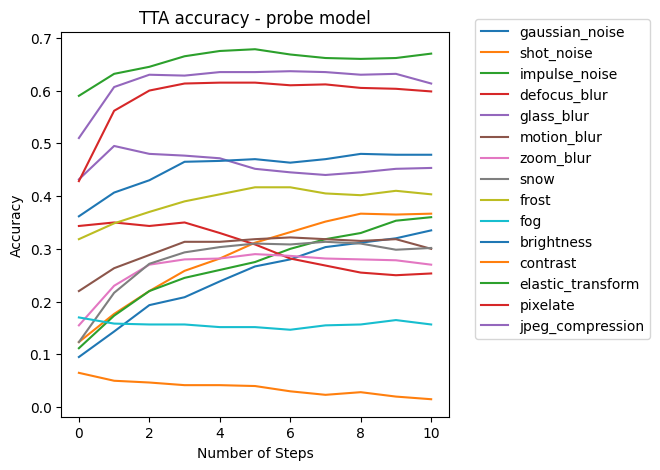

In [83]:
figsize(5,5)
xs = list(range(0,11))
for i, row in synced_TTA.iterrows():
    ys = [row[f'step{i}'] for i in range(0, 11)]
    plt.plot(xs, ys, label=row['corruption'])
    plt.legend(bbox_to_anchor=(1.05, 1.05))

plt.xlabel('Number of Steps')
plt.ylabel('Accuracy')
_=plt.title('TTA accuracy - probe model')
plt.savefig('figures/adaptation_curves.png', bbox_inches='tight')

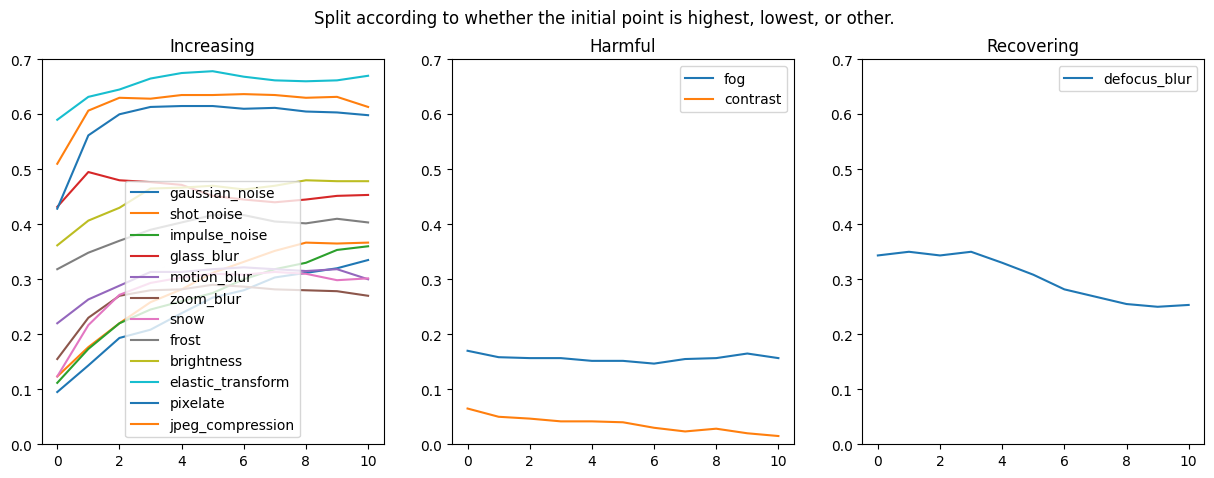

In [85]:
figsize(15, 5)
plt.subplots(1,3)
plt.suptitle('Split according to whether the initial point is highest, lowest, or other.')

plt.subplot(1,3,1)
plt.title('Increasing')
plt.ylim([0, 0.7])
plt.subplot(1,3,2)
plt.title('Harmful')
plt.ylim([0, 0.7])
plt.subplot(1,3,3)
plt.title('Recovering')
plt.ylim([0, 0.7])

xs = list(range(0, 11))
for i, row in synced_TTA.iterrows():
    ys = [row[f'step{i}'] for i in range(11)]
    if np.array(ys).argmin() == 0:
        plt.subplot(1,3,1)
    else:
        if np.array(ys).argmax() == 0:
            plt.subplot(1,3,2)
        else:
            plt.subplot(1,3,3)

    plt.plot(xs, ys, label=row['corruption'])
    plt.legend()

Firstly, it's worth noting that we see some of the best generalization performances yet observed. There are a couple of decreases, but these are quite weak.

I think that it is still worth sticking with this system, but these results mean that the illustration will likely be much less dramatic.